## Zeroth Step
### Importing Libraries and Loading Data

In [42]:
GC.gc() # Clear up the memory when doing a "run all" in the notebook

using Plots
using Dates

include("src/loader.jl")
include("src/utils.jl")
include("src/solver.jl");

In [43]:
filename = "data/profiles.csv"
YEARS = [2014, 2015, 2016, 2017, 2018]
if ! @isdefined(time_profiles) || issubset(YEARS, keys(time_profiles)) == false
    time_profiles, wind_profiles, solar_profiles = load_profiles(filename, years = YEARS, verbose = true)
end;

print("Loaded profiles for years: ", keys(time_profiles), "\n")

Loaded profiles for years: Any[2018, 2014, 2017, 2016, 2015]


### We first define the global parameters of the problem, to have consistent results across solving methods

In [44]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # MWh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
CAPA_ELEC_UPPER = 1000. # MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 750. # € / MWh;
PRICE_PENALITY = 1. # € / kg of change in production level
# Renewable pricing, from https://atb.nrel.gov/electricity/2022/index
# For now : 20 year lifespan, no discount rate + O&M cost per year
COST_WIND = 1352 * 1000 / 20 + 43 * 1000 # € / MW
COST_SOLAR = 1233 * 1000 / 20 + 23 * 1000 # € / MW
# Upper bound on the battery capacity
CAPA_BAT_UPPER = 12 * DEMAND * EELEC # MW
#Year chosen for the simulation
YEAR = 2014;

# First Step :
## Solve the problem given the production and storage capacities

In [45]:
# We use the default values for now
BAT_SIZE = 400. # MWh
TANK_SIZE = 500. # Kg
ELEC_CAPA = 1000. # MW
time_index = time_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = DEMAND * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [46]:
output1 = solve(
    wind_profile = wind_profile,
    solar_profile = solar_profile,
    demand = DEMAND,
    wind_capa = wind_capa,
    solar_capa = solar_capa,
    battery_capa = BAT_SIZE,
    tank_capa = TANK_SIZE,
    electro_capa = ELEC_CAPA,
    price_grid = PRICE_GRID,
    price_curtailing = PRICE_CURTAILING,
    price_penality = PRICE_PENALITY,
    cost_wind = COST_WIND,
    cost_solar = COST_SOLAR,
    cost_elec = COST_ELEC,
    cost_bat = COST_BAT,
    cost_tank = COST_TANK,
    ebat = EBAT,
    fbat = FBAT,
    eelec = EELEC,
    capa_elec_upper = CAPA_ELEC_UPPER,
    capa_bat_upper = CAPA_BAT_UPPER,
    verbose = true
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ...
Adding constraints ...
Solving the model ...
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96364 rows, 87605 columns and 245279 nonzeros
Model fingerprint: 0x2670484b
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-01, 4e+07]
Presolve removed 70138 rows and 35150 columns
Presolve time: 0.13s
Presolved: 26226 rows, 52455 columns, 104851 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 7.849e+04
 Factor NZ  : 3.797e+05 (roughly 35 MB of memory)
 Factor Ops : 6.367e+06 (less than 1 second pe

In [47]:
print_solution_propreties(
    output = output1,
    time = time_index,
    wind = wind_profile,
    solar = solar_profile
    )

Battery capacity: 400.0 MWh, Tank capacity: 500.0 kg, Electrolyser capacity: 20000.0 kg/h
Wind capacity: 231.57957918279348 MW, Solar capacity: 129.92603002328102 MW 

Wind proportion in capacity: 0.6405974714787418 
Wind proportion in generation: 0.75 

Total electricity needed: 438000.0 MWh, Total electricity produced: 459900.0 MWh
Total electricity imported: 81905.0 MWh, Total electricity curtailment: 103589.0 MWh 

Produced / Needed ratio : 1.0 

Storage cost: 223500.0, operating cost: 1.59600302e8
Electrolyser cost : 480000.0, electricity plant cost: 3.6610939e7
Total cost: 1.96914742e8


In [48]:
prod1, cons1, bat1, tank1 = plot_solution(
    output = output1,
    demand = DEMAND,
    time = time_index
);

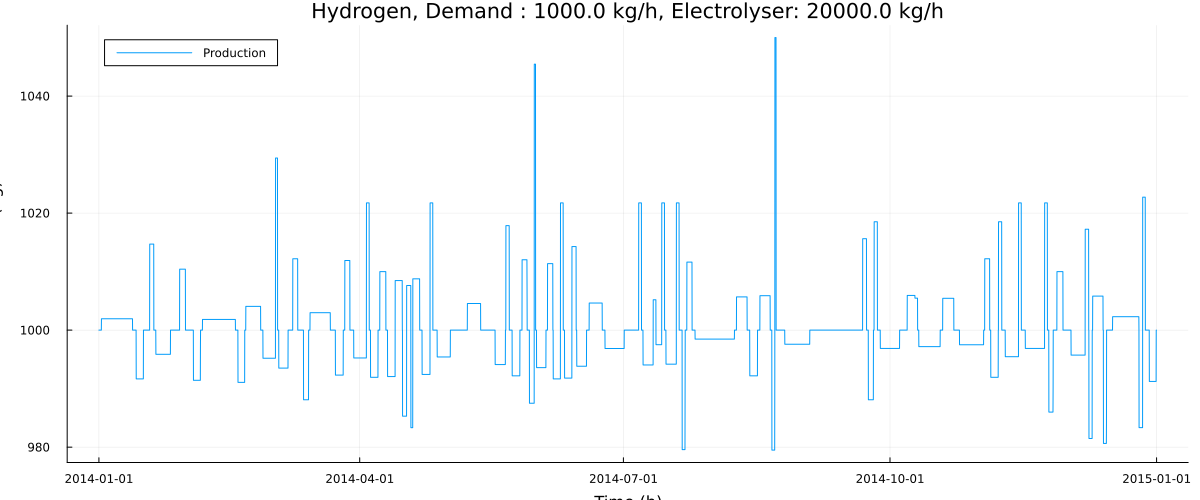

In [49]:
prod1

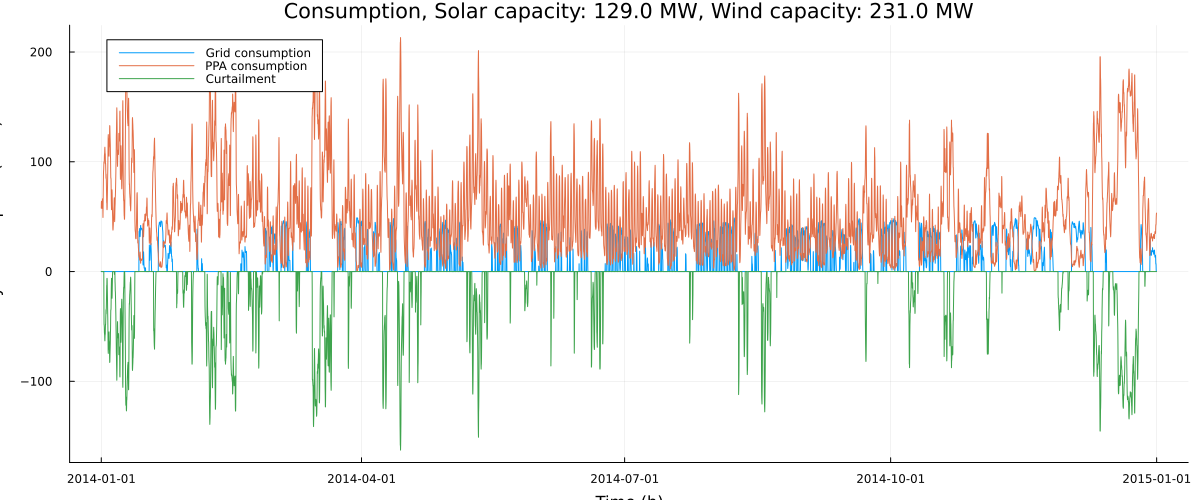

In [50]:
cons1

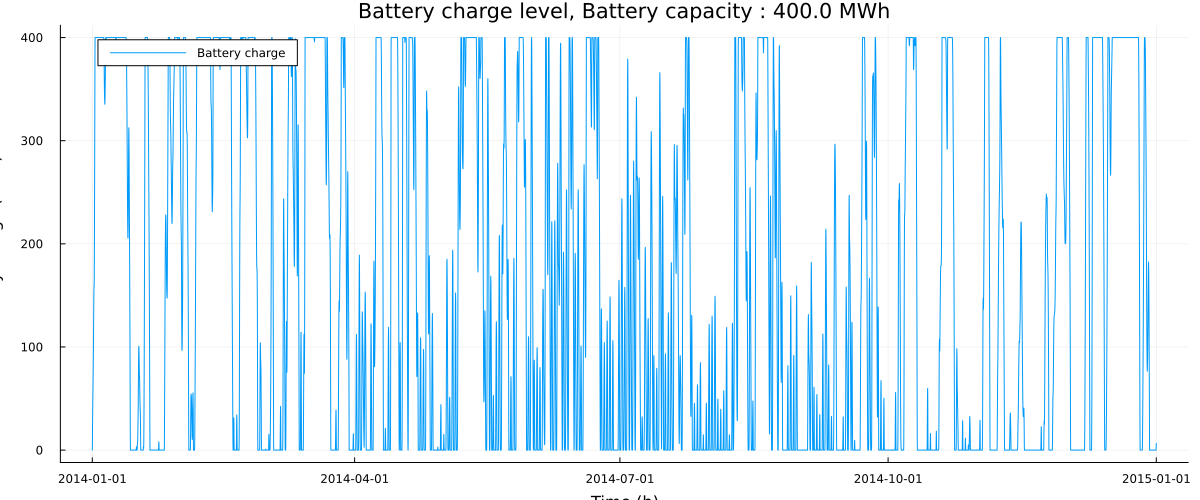

In [51]:
bat1

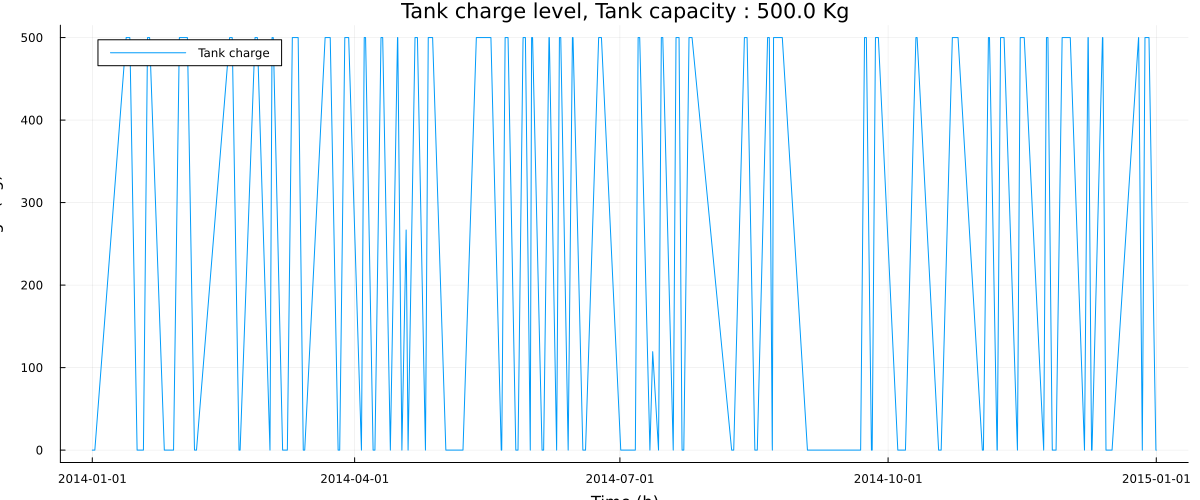

In [52]:
tank1

# Second Step :
## Solve the problem given the production capacities only

In [53]:
# We use the default values for now
time_index = time_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = DEMAND * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [54]:
output2 = solve(
    wind_profile = wind_profile,
    solar_profile = solar_profile,
    demand = DEMAND,
    wind_capa = wind_capa,
    solar_capa = solar_capa,
    price_grid = PRICE_GRID,
    price_curtailing = PRICE_CURTAILING,
    price_penality = PRICE_PENALITY,
    cost_wind = COST_WIND,
    cost_solar = COST_SOLAR,
    cost_elec = COST_ELEC,
    cost_bat = COST_BAT,
    cost_tank = COST_TANK,
    ebat = EBAT,
    fbat = FBAT,
    eelec = EELEC,
    capa_elec_upper = CAPA_ELEC_UPPER,
    capa_bat_upper = CAPA_BAT_UPPER,
    verbose = true
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ...
Adding constraints ...
Solving the model ...
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96364 rows, 87608 columns and 271564 nonzeros
Model fingerprint: 0x25100a39
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+03]
  RHS range        [8e-01, 4e+07]
Presolve removed 35043 rows and 26284 columns
Presolve time: 0.35s
Presolved: 18321 rows, 70083 columns, 237288 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Free vars  : 764
 AA' NZ     : 1.155e+05
 Factor NZ  : 2.726e+05 (roughly 40 MB of memory)
 Factor Ops : 4.398e+06 (les

In [55]:
print_solution_propreties(
    output = output2,
    time = time_index,
    wind = wind_profile,
    solar = solar_profile
    )

Battery capacity: 600.0 MWh, Tank capacity: 85260.44272703207 kg, Electrolyser capacity: 1892.1262759383162 kg/h
Wind capacity: 231.57957918279348 MW, Solar capacity: 129.92603002328102 MW 

Wind proportion in capacity: 0.6405974714787418 
Wind proportion in generation: 0.75 

Total electricity needed: 438000.0 MWh, Total electricity produced: 459900.0 MWh
Total electricity imported: 35461.0 MWh, Total electricity curtailment: 54018.0 MWh 

Produced / Needed ratio : 1.0 

Storage cost: 3.4731e7, operating cost: 7.6035531e7
Electrolyser cost : 45411.0, electricity plant cost: 3.6610939e7
Total cost: 1.47422882e8


In [56]:
prod2, cons2, bat2, tank2 = plot_solution(
    output = output2,
    demand = DEMAND,
    time = time_index
);

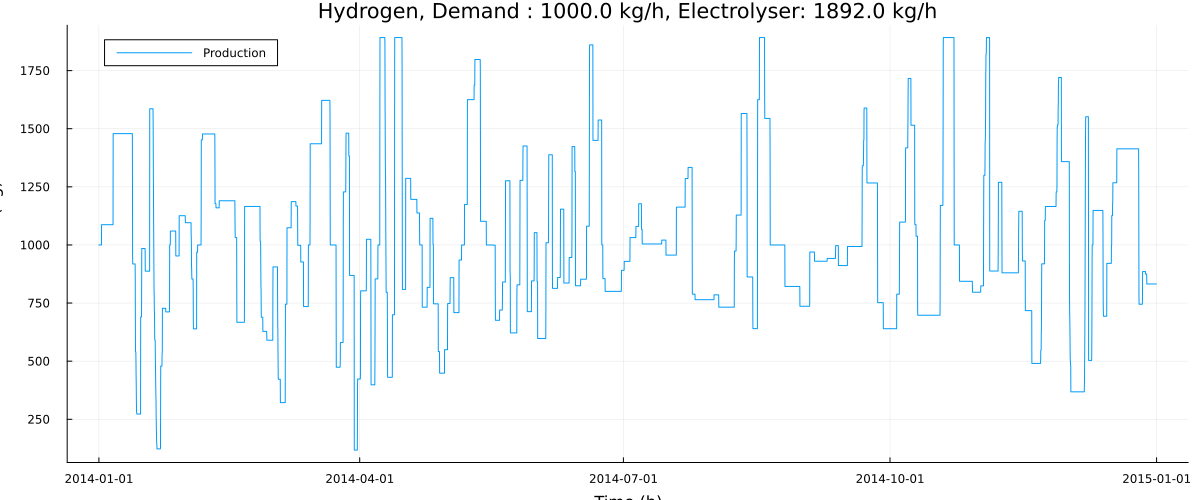

In [57]:
prod2

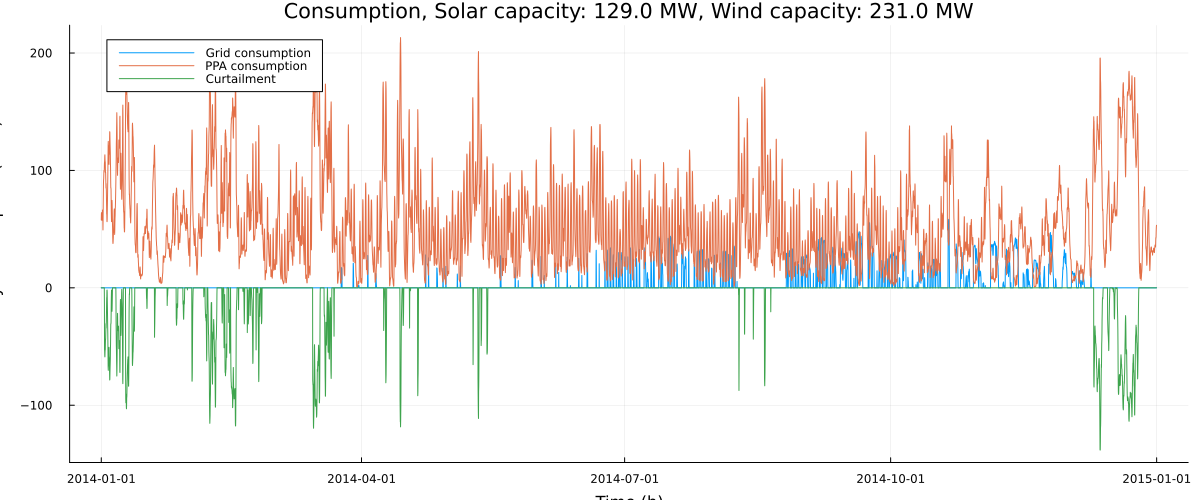

In [58]:
cons2

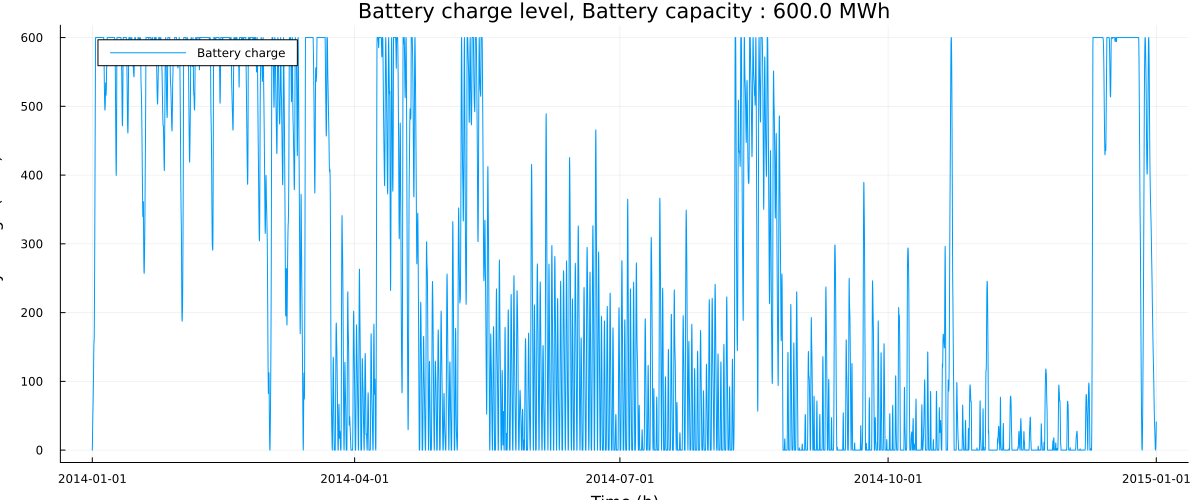

In [59]:
bat2

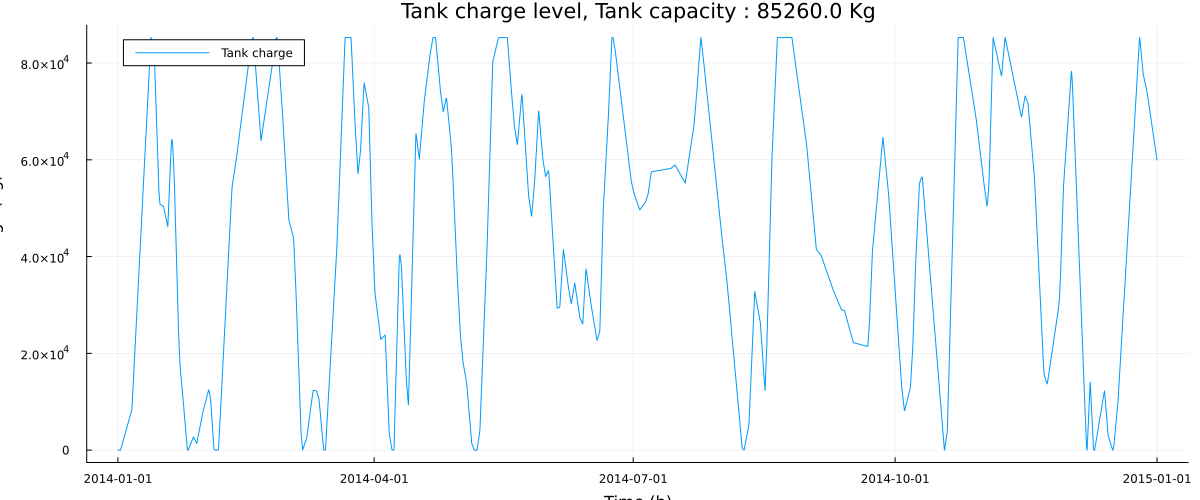

In [60]:
tank2

# Third Step : 
## Solve the problem given the demand only.

In [61]:
time_index = time_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR];

In [62]:
output3 = solve(
    wind_profile = wind_profile,
    solar_profile = solar_profile,
    demand = DEMAND,
    price_grid = PRICE_GRID,
    price_curtailing = PRICE_CURTAILING,
    price_penality = PRICE_PENALITY,
    cost_wind = COST_WIND,
    cost_solar = COST_SOLAR,
    cost_elec = COST_ELEC,
    cost_bat = COST_BAT,
    cost_tank = COST_TANK,
    ebat = EBAT,
    fbat = FBAT,
    eelec = EELEC,
    capa_elec_upper = CAPA_ELEC_UPPER,
    capa_bat_upper = CAPA_BAT_UPPER,
    verbose = true
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ...
Adding constraints ...
Solving the model ...
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96364 rows, 87610 columns and 285255 nonzeros
Model fingerprint: 0x10d9997f
Coefficient statistics:
  Matrix range     [1e-04, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+03]
  RHS range        [1e+03, 1e+03]
Presolve removed 35043 rows and 26284 columns
Presolve time: 0.38s
Presolved: 18323 rows, 70083 columns, 250977 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Free vars  : 773
 AA' NZ     : 1.432e+05
 Factor NZ  : 2.929e+05 (roughly 40 MB of memory)
 Factor Ops : 4.971e+06 (les

In [63]:
print_solution_propreties(
    output = output3,
    time = time_index,
    wind = wind_profile,
    solar = solar_profile
    )

Battery capacity: 600.0 MWh, Tank capacity: 66340.18570923411 kg, Electrolyser capacity: 1665.1568743023624 kg/h
Wind capacity: 135.54391556397354 MW, Solar capacity: 227.36962698949765 MW 

Wind proportion in capacity: 0.37348817189428163 
Wind proportion in generation: 0.5008431717763818 

Total electricity needed: 438000.0 MWh, Total electricity produced: 403090.0 MWh
Total electricity imported: 49151.0 MWh, Total electricity curtailment: 14553.0 MWh 

Produced / Needed ratio : 0.0 

Storage cost: 2.7030455e7, operating cost: 6.0104521e7
Electrolyser cost : 39963.0, electricity plant cost: 3.4237995e7
Total cost: 1.21412936e8


In [64]:
prod3, cons3, bat3, tank3 = plot_solution(
    output = output3,
    demand = DEMAND,
    time = time_index
);

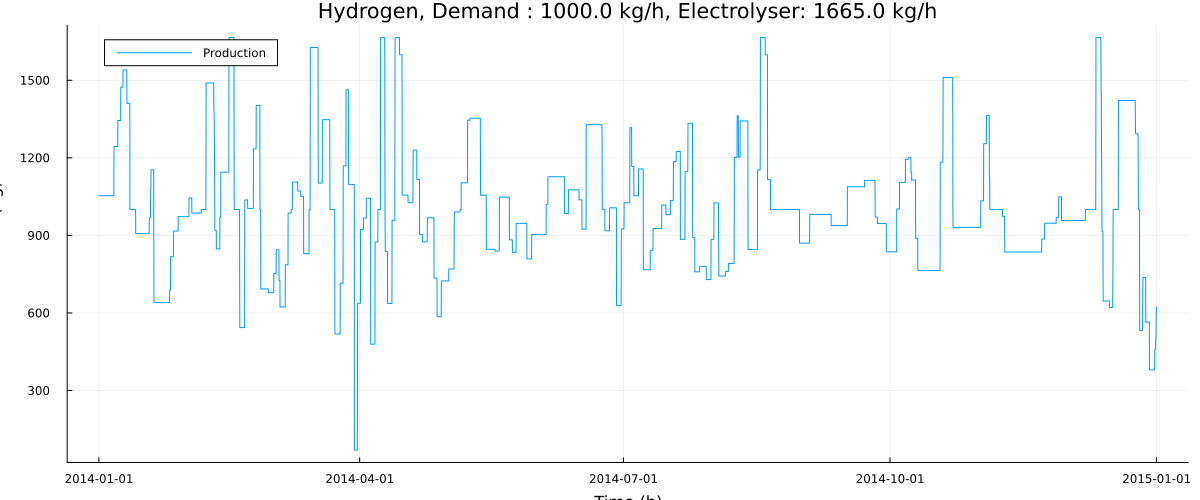

In [65]:
prod3

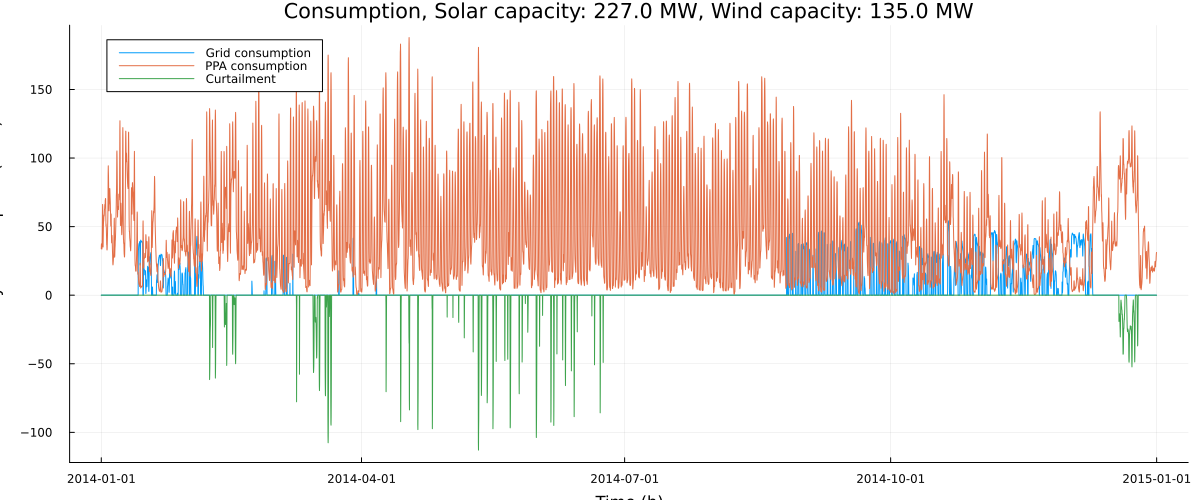

In [66]:
cons3

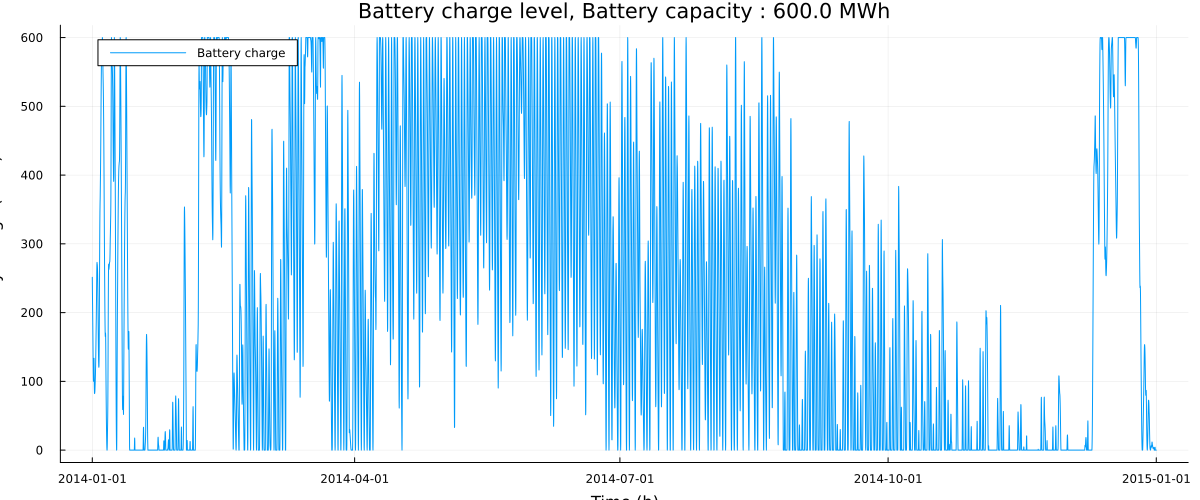

In [67]:
bat3

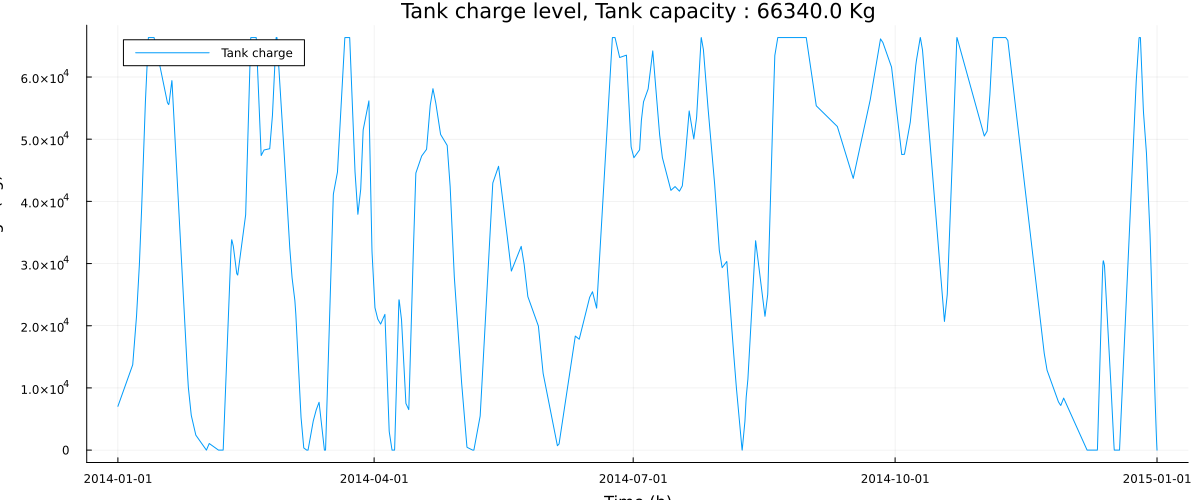

In [68]:
tank3